# Исследование надёжности заёмщиков

Нужно разобраться, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок. Входные данные от банка — статистика о платёжеспособности клиентов. Результаты исследования будут учтены при построении модели **кредитного скоринга**.

Источник данных: **Яндекс.Практикум**

In [1]:
import pandas as pd
import nltk
nltk.download('wordnet')
from pymorphy2 import MorphAnalyzer
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter('ignore')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\erokh\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Предобработка и исследовательсикий анализ данных

In [2]:
df = pd.read_csv('C:/Users/erokh/Downloads/data.csv')
display(df.head(10))
print('-----------------------------------------------------------------')
df.info()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу
5,0,-926.185831,27,высшее,0,гражданский брак,1,M,компаньон,0,255763.565419,покупка жилья
6,0,-2879.202052,43,высшее,0,женат / замужем,0,F,компаньон,0,240525.971920,операции с жильем
7,0,-152.779569,50,СРЕДНЕЕ,1,женат / замужем,0,M,сотрудник,0,135823.934197,образование
8,2,-6929.865299,35,ВЫСШЕЕ,0,гражданский брак,1,F,сотрудник,0,95856.832424,на проведение свадьбы
9,0,-2188.756445,41,среднее,1,женат / замужем,0,M,сотрудник,0,144425.938277,покупка жилья для семьи


-----------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


**Вывод**

Изучено содержание столбцов, их типы и количество. Сразу заметны такие аномалии, как:
1. Отрицательные значения в количестве проработанных дней
2. Разные размеры строк в стобце education
3. Пропуски в столбцах days_employed, total_income      

In [3]:
#Рассмотрим столбцы с категориальными данными
display(df.describe())

for col in df.columns:
    
    if df[col].dtype == "object":
    
        print(col)
        print(df[col].unique())
        print()

,children,days_employed,dob_years,education_id,family_status_id,debt,total_income
count,21525.000000,19351.000000,21525.000000,21525.000000,21525.000000,21525.000000,1.935100e+04
mean,0.538908,63046.497661,43.293380,0.817236,0.972544,0.080883,1.674223e+05
std,1.381587,140827.311974,12.574584,0.548138,1.420324,0.272661,1.029716e+05
min,-1.000000,-18388.949901,0.000000,0.000000,0.000000,0.000000,2.066726e+04
25%,0.000000,-2747.423625,33.000000,1.000000,0.000000,0.000000,1.030532e+05
50%,0.000000,-1203.369529,42.000000,1.000000,0.000000,0.000000,1.450179e+05
75%,1.000000,-291.095954,53.000000,1.000000,1.000000,0.000000,2.034351e+05
max,20.000000,401755.400475,75.000000,4.000000,4.000000,1.000000,2.265604e+06


education
['высшее' 'среднее' 'Среднее' 'СРЕДНЕЕ' 'ВЫСШЕЕ' 'неоконченное высшее'
 'начальное' 'Высшее' 'НЕОКОНЧЕННОЕ ВЫСШЕЕ' 'Неоконченное высшее'
 'НАЧАЛЬНОЕ' 'Начальное' 'Ученая степень' 'УЧЕНАЯ СТЕПЕНЬ'
 'ученая степень']

family_status
['женат / замужем' 'гражданский брак' 'вдовец / вдова' 'в разводе'
 'Не женат / не замужем']

gender
['F' 'M' 'XNA']

income_type
['сотрудник' 'пенсионер' 'компаньон' 'госслужащий' 'безработный'
 'предприниматель' 'студент' 'в декрете']

purpose
['покупка жилья' 'приобретение автомобиля' 'дополнительное образование'
 'сыграть свадьбу' 'операции с жильем' 'образование'
 'на проведение свадьбы' 'покупка жилья для семьи' 'покупка недвижимости'
 'покупка коммерческой недвижимости' 'покупка жилой недвижимости'
 'строительство собственной недвижимости' 'недвижимость'
 'строительство недвижимости' 'на покупку подержанного автомобиля'
 'на покупку своего автомобиля' 'операции с коммерческой недвижимостью'
 'строительство жилой недвижимости' 'жилье'
 'операци

###### Вывод
В категориальных данных видны некоторые аномилии:
1. В столбце 'gender' присутствует значение 'XNA', чего быть не может;
2. В столбце 'education' присутствует несколько переменных, которые обозначают одно и то же. Например, есть несколько вариаций написания слова 'среднее'.
3. В столбце 'purpose' присутствует достаточно много уникальных значений, однако, при более внимательном изучении их все можно выделить в основные категории, например, 'жилье' или 'автомобиль'


### Обработка пропусков

Определяем столбцы с пропусками

In [4]:
df.isna().sum()

children               0
days_employed       2174
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income        2174
purpose                0
dtype: int64

In [5]:
columns_with_na = df[['days_employed', 'total_income']] #столбцы, в которых присутствуют пропуски
columns_with_na_drop_null = columns_with_na[columns_with_na[['days_employed', 'total_income']] != 0] #оставляем только ненулевые значения
columns_with_na_drop_null['days_employed'] = columns_with_na_drop_null['days_employed'].abs() #убераем отрицательные значения количества проработанных дней
columns_with_na_drop_null = round(columns_with_na_drop_null)

#доля пропущенных значений от общего количества значений составляет 10%
isnull_share = len(df[df['days_employed'].isna()])/len(df)
print('доля пропущенных значений от общего количества значений:', isnull_share)

#заменяем пропуски на нули, чтобы в дальнейшем подставить ни их место медиану
df[['days_employed', 'total_income']] = df[['days_employed', 'total_income']].fillna(0)
df.info() #пропуски отсутствуют, везде одинаковое количество строк

доля пропущенных значений от общего количества значений: 0.10099883855981417
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     21525 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      21525 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


In [6]:
df['children'].value_counts() #замечено аномальное значение в количестве детей (-1)

 0     14149
 1      4818
 2      2055
 3       330
 20       76
-1        47
 4        41
 5         9
Name: children, dtype: int64

### Описательные статистики

#### Максимальные / минимальные значения

In [7]:
df['children'] = df['children'].abs() #убираем отрицательные значения

max_value_days_employed = columns_with_na_drop_null['days_employed'].max()
print('Максимальное значение общего трудового стажа:', max_value_days_employed)

max_value_total_income = columns_with_na_drop_null['total_income'].max()
print('Максимальное значение ежемесячного дохода:', max_value_total_income)
print('')

min_value_days_employed = columns_with_na_drop_null['days_employed'].min()
print(f'Минимальное значение общего трудового стажа:', min_value_days_employed)

min_value_total_income = columns_with_na_drop_null['total_income'].min()
print('Минимальное значение ежемесячного дохода:', min_value_days_employed)

Максимальное значение общего трудового стажа: 401755.0
Максимальное значение ежемесячного дохода: 2265604.0

Минимальное значение общего трудового стажа: 24.0
Минимальное значение ежемесячного дохода: 24.0


**Можем заметить, что:**
1. Огромная разница в максимальных и минимальных значениях
2. Максимальное значение общего трудового стажа принимает неестественно большие значения (401755 дней - 1100 лет, столько люди не живут:))

#### Медиана, среднее

In [8]:
#Замена нулевых значений в столбце total_income
med_salary = df.groupby('income_type')['total_income'].transform('median') #создаем переменные по медиане зарплаты для каждого типа занятости
df.loc[df['total_income']==0, 'total_income']=med_salary #заменяем пропуски медианой по каждой группе

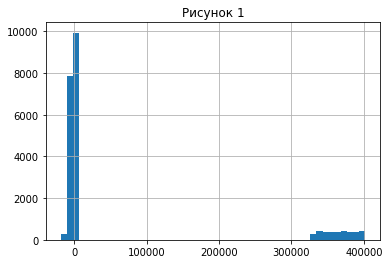

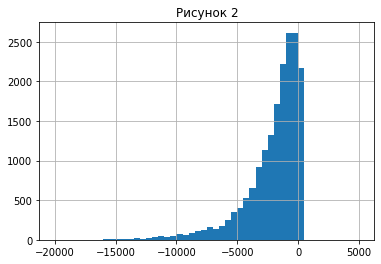

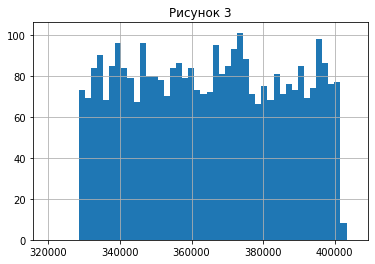

In [9]:
#Замена нулевых значений в столбце days_employed
df['days_employed'].hist(bins = 50)
plt.title('Рисунок 1')
plt.show()
df['days_employed'].hist(bins = 50, range = (-20000, 5000))
plt.title('Рисунок 2')
plt.show()
df['days_employed'].hist(bins = 50, range = (320000, 405000))
plt.title('Рисунок 3')
plt.show()

**На основе данных гистограмм можно заметить, что данные по количеству проработанных дней разбросаны на 2 группы. Первая группа от -18388 до ~500, вторая группа от 315000 до 405000 часов. Вторая группа имеет аномально большое количество часов. Можно предположить, что:**
1. Первая группы имеет отрицательные значения из за ошибки выгрузки и на самом деле это настоящие данные, но только со знаком минус.
2. Вторая группа имеет столь высокие значения из за того, что указывали трудовой стаж не в днях, а в часах.

In [10]:
df['days_employed'] = df['days_employed'].apply(lambda x: x/24 if x>320000  else abs(x)) #все дни, где значение столбца больше 
#320000 происходит деление на 24

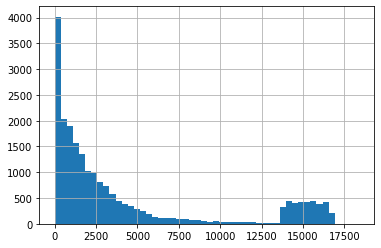

In [11]:
df['days_employed'].hist(bins = 50)
plt.show()

После обработки аномальных значений график стал выглядеть более правдоподобно. Единственная аномалия, которая осталось - это большое количество значений в диапазоне от 13000 до 17000.

**Вывод**

Были заменены отсутствующие значения в столбцах total_income и days_employed на нули, а затем на средние значения для каждого типа занятости. Вариант удаления строк с пропусками, поскольку подобные стоки составляют 10% от общего количества зачений. Потеря подобного количества строк могла существенно отразиться на конечных результатах.

### Замена типа данных

In [12]:
df['days_employed'] = df['days_employed'].astype('int')
df['total_income'] = df['total_income'].astype('int')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   children          21525 non-null  int64 
 1   days_employed     21525 non-null  int32 
 2   dob_years         21525 non-null  int64 
 3   education         21525 non-null  object
 4   education_id      21525 non-null  int64 
 5   family_status     21525 non-null  object
 6   family_status_id  21525 non-null  int64 
 7   gender            21525 non-null  object
 8   income_type       21525 non-null  object
 9   debt              21525 non-null  int64 
 10  total_income      21525 non-null  int32 
 11  purpose           21525 non-null  object
dtypes: int32(2), int64(5), object(5)
memory usage: 1.8+ MB


### Обработка дубликатов

In [13]:
df['education'].value_counts()

среднее                13750
высшее                  4718
СРЕДНЕЕ                  772
Среднее                  711
неоконченное высшее      668
ВЫСШЕЕ                   274
Высшее                   268
начальное                250
Неоконченное высшее       47
НЕОКОНЧЕННОЕ ВЫСШЕЕ       29
НАЧАЛЬНОЕ                 17
Начальное                 15
ученая степень             4
Ученая степень             1
УЧЕНАЯ СТЕПЕНЬ             1
Name: education, dtype: int64

In [14]:
#Перед поиском дубликатов подводим все стобцы с текстовыми значениями к одному формату, затем ищем дубликаты и избавляемся от них
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].str.lower()
    

print(df['gender'].unique()) #обнуружено значение 'xna'
print('')

display(df.loc[df['gender']=='xna'])
print('')

df = df.drop(df[df['gender']=='xna'].index) #избавляемся от строки с xna
print(df['gender'].unique()) #проверка уникальных значений

['f' 'm' 'xna']



,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
10701,0,2358,24,неоконченное высшее,2,гражданский брак,1,xna,компаньон,0,203905,покупка недвижимости



['f' 'm']


In [15]:
print('Обнаружено дубликатов:', df.duplicated().sum()) #обнаружен 71 дубликат
print('')
df = df.drop_duplicates().reset_index(drop=True) #избавляемся от дубликатов
print('Осталось дубликатов:', df.duplicated().sum())

Обнаружено дубликатов: 71

Осталось дубликатов: 0


**Вывод**

Было обнаружено аномальное значение (XNA) в столбце gender и убрано. Для нахождения наибольшего колечества дубликатов строки были стандартизированы и убраны разные размеры шрифтов, после осуществлялся поиск дубликатов с последующим удалением.

### Лемматизация

Для того, чтобы уменьшить количество уникальных причин для взятия кредита необходимо провести лемматизацию.

In [16]:
list_of_purposes = df['purpose'].value_counts() #находим все цели получения кредита
print(df['purpose'].value_counts()) #поскольку причин немного, то проще выделить основные цели зрительно

свадьба                                   791
на проведение свадьбы                     768
сыграть свадьбу                           765
операции с недвижимостью                  675
покупка коммерческой недвижимости         661
операции с жильем                         652
покупка жилья для сдачи                   651
операции с коммерческой недвижимостью     650
жилье                                     646
покупка жилья                             646
покупка жилья для семьи                   638
строительство собственной недвижимости    635
недвижимость                              633
операции со своей недвижимостью           627
строительство жилой недвижимости          624
покупка недвижимости                      620
покупка своего жилья                      620
строительство недвижимости                619
ремонт жилью                              607
покупка жилой недвижимости                606
на покупку своего автомобиля              505
заняться высшим образованием      

In [17]:
#Функция для лемматизации столбца purpose
morph = MorphAnalyzer()

def create_category_purpose(row):
    purpose = row['purpose']
    tokens = nltk.word_tokenize(purpose)
    lemms_list_of_lists = [morph.normal_forms(x) for x in tokens]
    lemms_final = list(map(lambda x: x[0], lemms_list_of_lists))
    if 'автомобиль' in lemms_final:
        return 'автомобиль'
    if 'образование' in lemms_final:
        return 'образование'
    if 'недвижимость' in lemms_final or 'жильё' in lemms_final:
        return 'недвижимость'
    if 'свадьба' in lemms_final:
        return 'свадьба'

In [18]:
df['lemmed_purpose'] = df.apply(create_category_purpose, axis=1) #создание столбца с основными целями получения кредита 
print(df['lemmed_purpose'].value_counts()) #данный вывод нужен для: 
# 1) Проверки того, что отсутствуют пропуски и какие то другие значени
# 2) Из этого можно сделать вывод о том, на какие нужды люди берут кредиты чаще всего (с большим отрывом лидирует недвижимость)

недвижимость    10810
автомобиль       4306
образование      4013
свадьба          2324
Name: lemmed_purpose, dtype: int64


**Вывод**

Для осуществления лемматизации были сначала найдены и выделены наиболее часто встречающиеся категории целей для получения кредита, далее были образованы леммы и создана функция для лемматзации всего списка. Из получившегося результата можно заметить, что "недвижимость" является наиболее частой причиной для взятия кредита, а свадьба ,наоборот, является наиболее редкой причиной для кредита.

### Категоризация данных

In [19]:
df['total_income'] = df['total_income'].astype('int')

df['total_income_category'] = pd.qcut(df['total_income'], 4, labels=["низкий заработок", "средний заработок", "выше среднего", "высокий заработок"])
print(df['total_income_category'].value_counts())

низкий заработок     5364
средний заработок    5363
выше среднего        5363
высокий заработок    5363
Name: total_income_category, dtype: int64


In [20]:
debt_data = df.loc[df['debt']==1] #создаем список клиентов с заделженностью

debt_share = len(debt_data)/len(df['debt'])
print('{:.1%} всех клиентов банка имеют задоженность'.format(debt_share))

8.1% всех клиентов банка имеют задоженность


In [21]:
low_earnings = df.loc[df['total_income_category']=='низкий заработок']
low_earnings_debt = low_earnings.loc[low_earnings['debt']==1]
low_earnings_debt_share = len(low_earnings_debt)/len(low_earnings)
print('Доля клиентов с задолженностью из категории низкий заработок составляет {:.1%}'.format(low_earnings_debt_share))

middle_earnings = df.loc[df['total_income_category']=='средний заработок']
middle_earnings_debt = middle_earnings.loc[middle_earnings['debt']==1]
middle_earnings_debt_share = len(middle_earnings_debt)/len(middle_earnings)
print('Доля клиентов с задолженностью из категории средний заработок составляет {:.1%}'.format(middle_earnings_debt_share))

more_than_avarage = df.loc[df['total_income_category']=='выше среднего']
more_than_avarage_debt = more_than_avarage.loc[more_than_avarage['debt']==1]
more_than_avarage_debt_share = len(more_than_avarage_debt)/len(more_than_avarage)
print('Доля клиентов с задолженностью из категории заработок выше среднего составляет {:.1%}'.format(more_than_avarage_debt_share))

high_earnings = df.loc[df['total_income_category']=='высокий заработок']
high_earnings_debt = high_earnings.loc[high_earnings['debt']==1]
high_earnings_debt_share = len(high_earnings_debt)/len(high_earnings)
print('Доля клиентов с задолженностью из категории высокий заработок составляет {:.1%}'.format(high_earnings_debt_share))

Доля клиентов с задолженностью из категории низкий заработок составляет 8.0%
Доля клиентов с задолженностью из категории средний заработок составляет 8.6%
Доля клиентов с задолженностью из категории заработок выше среднего составляет 8.8%
Доля клиентов с задолженностью из категории высокий заработок составляет 7.1%


**Вывод**

Категоризация осуществлялась по стобцу total_income. Были выделены такие категории, как: 'низкий заработок', 'средний заработок', 'выше среднего', 'высокий заработок'. После было подсчитано количество клиентов и долю задолженности в каждой категории и сделан вывод о том, что доход оказывает влияние на возврат кредита в срок, поскольку доля задолженности меняется в зависимости от группы. Можно сделать интересный вывод: процент задолженности растет с увеличением заработка, однако для тех, у кого высокий заработок процент невозврата наименьший и составляет 7.1%, в то время, как для категории клиентов с заработком выше среднего процент задолженности наибольший и составляет 8.8%.

## Ответы на вопросы

**- Есть ли зависимость между наличием детей и возвратом кредита в срок?**

In [22]:
print(df['children'].value_counts()) #Полагаю, что 20 детей можно считать выбросом и удалить
df=df.drop(df.loc[df['children']==20].index)
print('')
print(df['children'].value_counts())

0     14090
1      4855
2      2052
3       330
20       76
4        41
5         9
Name: children, dtype: int64

0    14090
1     4855
2     2052
3      330
4       41
5        9
Name: children, dtype: int64


**Так как некоторые группы, например семьи с 4-5 детьми слишком маленькие по кол-ву и делать по ним суждения нельзя, то нужно провести категоризацию: без детей \ малодетная (1-2) \ многодетная (от 3х).**

In [23]:
#Функция для категоризации семей

def children_f(children):
    if children==0:
        return 'без детей'
    if children == 1 or children == 2:
        return 'малодетная'
    else:
        return 'многодетная'

df['family_type'] = df['children'].apply(children_f)
children_pivot = df.pivot_table(index='family_type', values='debt')
round(children_pivot['debt'] * 100, 1)

family_type
без детей      7.5
малодетная     9.3
многодетная    8.2
Name: debt, dtype: float64

**Вывод**

Зависимость между наличием детей и возвратом кредита в срок присутствует, поскольку доля должников в каждой из групп меняется. Так, меньше всего проблем с погашением кредита в срок имеют клиенты без детей, доля должников среди них составляет 7.5%. Больше всего сложностей с погашением кредита в срок имеют клиенты, у которых имеется 1 или 2 ребенка, доля должников среди них составляет 9.3%.

**- Есть ли зависимость между семейным положением и возвратом кредита в срок?**

In [24]:
print(df.groupby('family_status')['debt'].count())
print('')
print('Количество человек в каждой категории')
print('')

print(df.groupby('family_status')['debt'].sum())
print('')
print('Количество невозвратов в каждой категории')

display(round(df.pivot_table(index = ['family_status'],values=['debt'])['debt'] * 100, 1))
print('Количество невозвратов в % по каждой категории')

family_status
в разводе                 1193
вдовец / вдова             955
гражданский брак          4138
женат / замужем          12290
не женат / не замужем     2801
Name: debt, dtype: int64

Количество человек в каждой категории

family_status
в разводе                 84
вдовец / вдова            63
гражданский брак         385
женат / замужем          928
не женат / не замужем    273
Name: debt, dtype: int64

Количество невозвратов в каждой категории


family_status
в разводе                7.0
вдовец / вдова           6.6
гражданский брак         9.3
женат / замужем          7.6
не женат / не замужем    9.7
Name: debt, dtype: float64

Количество невозвратов в % по каждой категории


**Вывод**

Зависимость между семейным положением и возвратом кредита в срок существует. Наиболее надежными заемщиками являются клиенты из категории вдовец/вдова с долей задолженности в 6.6%, а наименее надежными заемщиками являются клиенты из категории не женат / не замужем с долей задолженности в 9.7%.

**- Есть ли зависимость между уровнем дохода и возвратом кредита в срок?**

In [25]:
round(df.pivot_table(index = ['total_income_category'],values=['debt'])['debt'] * 100, 1)

total_income_category
низкий заработок     8.0
средний заработок    8.6
выше среднего        8.7
высокий заработок    7.1
Name: debt, dtype: float64

**Вывод**  

Как можем заметить зависимость между уровнем дохода и возвратом кредита в срок присутствует, поскольку в каждой из групп процент задолженности разнится. Так, наименьший уровень задолженности,7.1%, у клиентов с высоким заработком, а наибольший, 8.7%, у клиентов с заработком выше среднего. Удивительно, но люди среднего дохода видимо хуже всех возвращают кредиты, даже хуже, чем люди с низким доходом. Возможно, люди низкого дохода более критически оценивают свои возможности, проходят куда более строгий скоринг, а людям с высоким доходом просто хватает стабильного заработка на погашение задолженностей. Средний класс вполне может слишком оптимистично относиться к своим финансовым возможностям.

**- Как разные цели кредита влияют на его возврат в срок?**

In [26]:
round(df.pivot_table(index = ['lemmed_purpose'],values=['debt'])['debt'] * 100, 1)

lemmed_purpose
автомобиль      9.3
недвижимость    7.2
образование     9.2
свадьба         7.9
Name: debt, dtype: float64

**Вывод**  

Исходя из вывода кода, приходим к тому, что зависимость между целями кредита и возвратом кредита в срок присутствует. Так, наибольший процент задолженности приходится на людей, у которых целью получения кредита является машина (9.3%). Наименьший процент задолженности приходится на людей, у которых целью получения кредита является недвижимость (7.2%).

## Шаг 4. Общий вывод

Основной задачей проекта было исследование надежности заемщиков, а именно оценить влияние  семейного положения и количества детей клиента на факт погашения кредита в срок. На основе проведенного анализа можно сделать следующие выводы: 
1. Зависимость между наличием детей и возвратом кредита в срок присутствует. Меньше всего проблем у семей без детей, больше всего у малодетных семей (1 - 2 ребенка).
2. Влияние семейного положения на погашение задолженности имеется. Наиболее надежными заемщиками являются клиенты из категории вдовец/вдова с долей задолженности в 6.5%, а наименьее надежными заемщиками являются клиенты из категории не женат / не замужем с долей задолженности в 9.7%.
3. Зависимость между уровнем дохода и возвратом кредита в срок присутствует. Наименьший уровень задолженности,7.1%, у клиентов с высоким заработком, а наибольший, 8.9%, у клиентов с заработком выше среднего.
4. Зависимость между целями кредита и возвратом кредита в срок присутствует. Так, наибольший процент задолженности приходится на людей, у которых целью получения кредита является машина (9.3%). Наименьший процент задолженности приходится на людей, у которых целью получения кредита является недвижимость (7.2%).